In [28]:
import json
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (16, 8)})

In [10]:
with open("data/saliency.json") as file:
    saliency = json.load(file)

reports = list(saliency)

In [11]:
def positive_saliency(report):
    sal = saliency[report]
    return { k: v for (k, v) in sal.items() if v > 0 }

In [12]:
sustainable_words = ["climate", "sustainable", "sustainability", "green", "long"]

In [13]:
def index(report, words = sustainable_words):
        
    isinwords = lambda k: any(word in k for word in words)
    
    sal = positive_saliency(report)
    
    total = sum(sal.values())
    sustainable = sum((v for (k, v) in sal.items() if isinwords(k)))
    
    return sustainable/total

In [19]:
groups = ["ANNUAL", "RI_REPORT", "STEWARDSHIP_POLICY"]

In [45]:
grouped_data = { g: {} for g in groups }

for report in reports:
    for group in groups:
        if group in report:
            company = report.replace(f"{group} ", "")
            grouped_data[group][company] = index(report)
            
            continue
            
df = pd.DataFrame.from_dict(grouped_data)

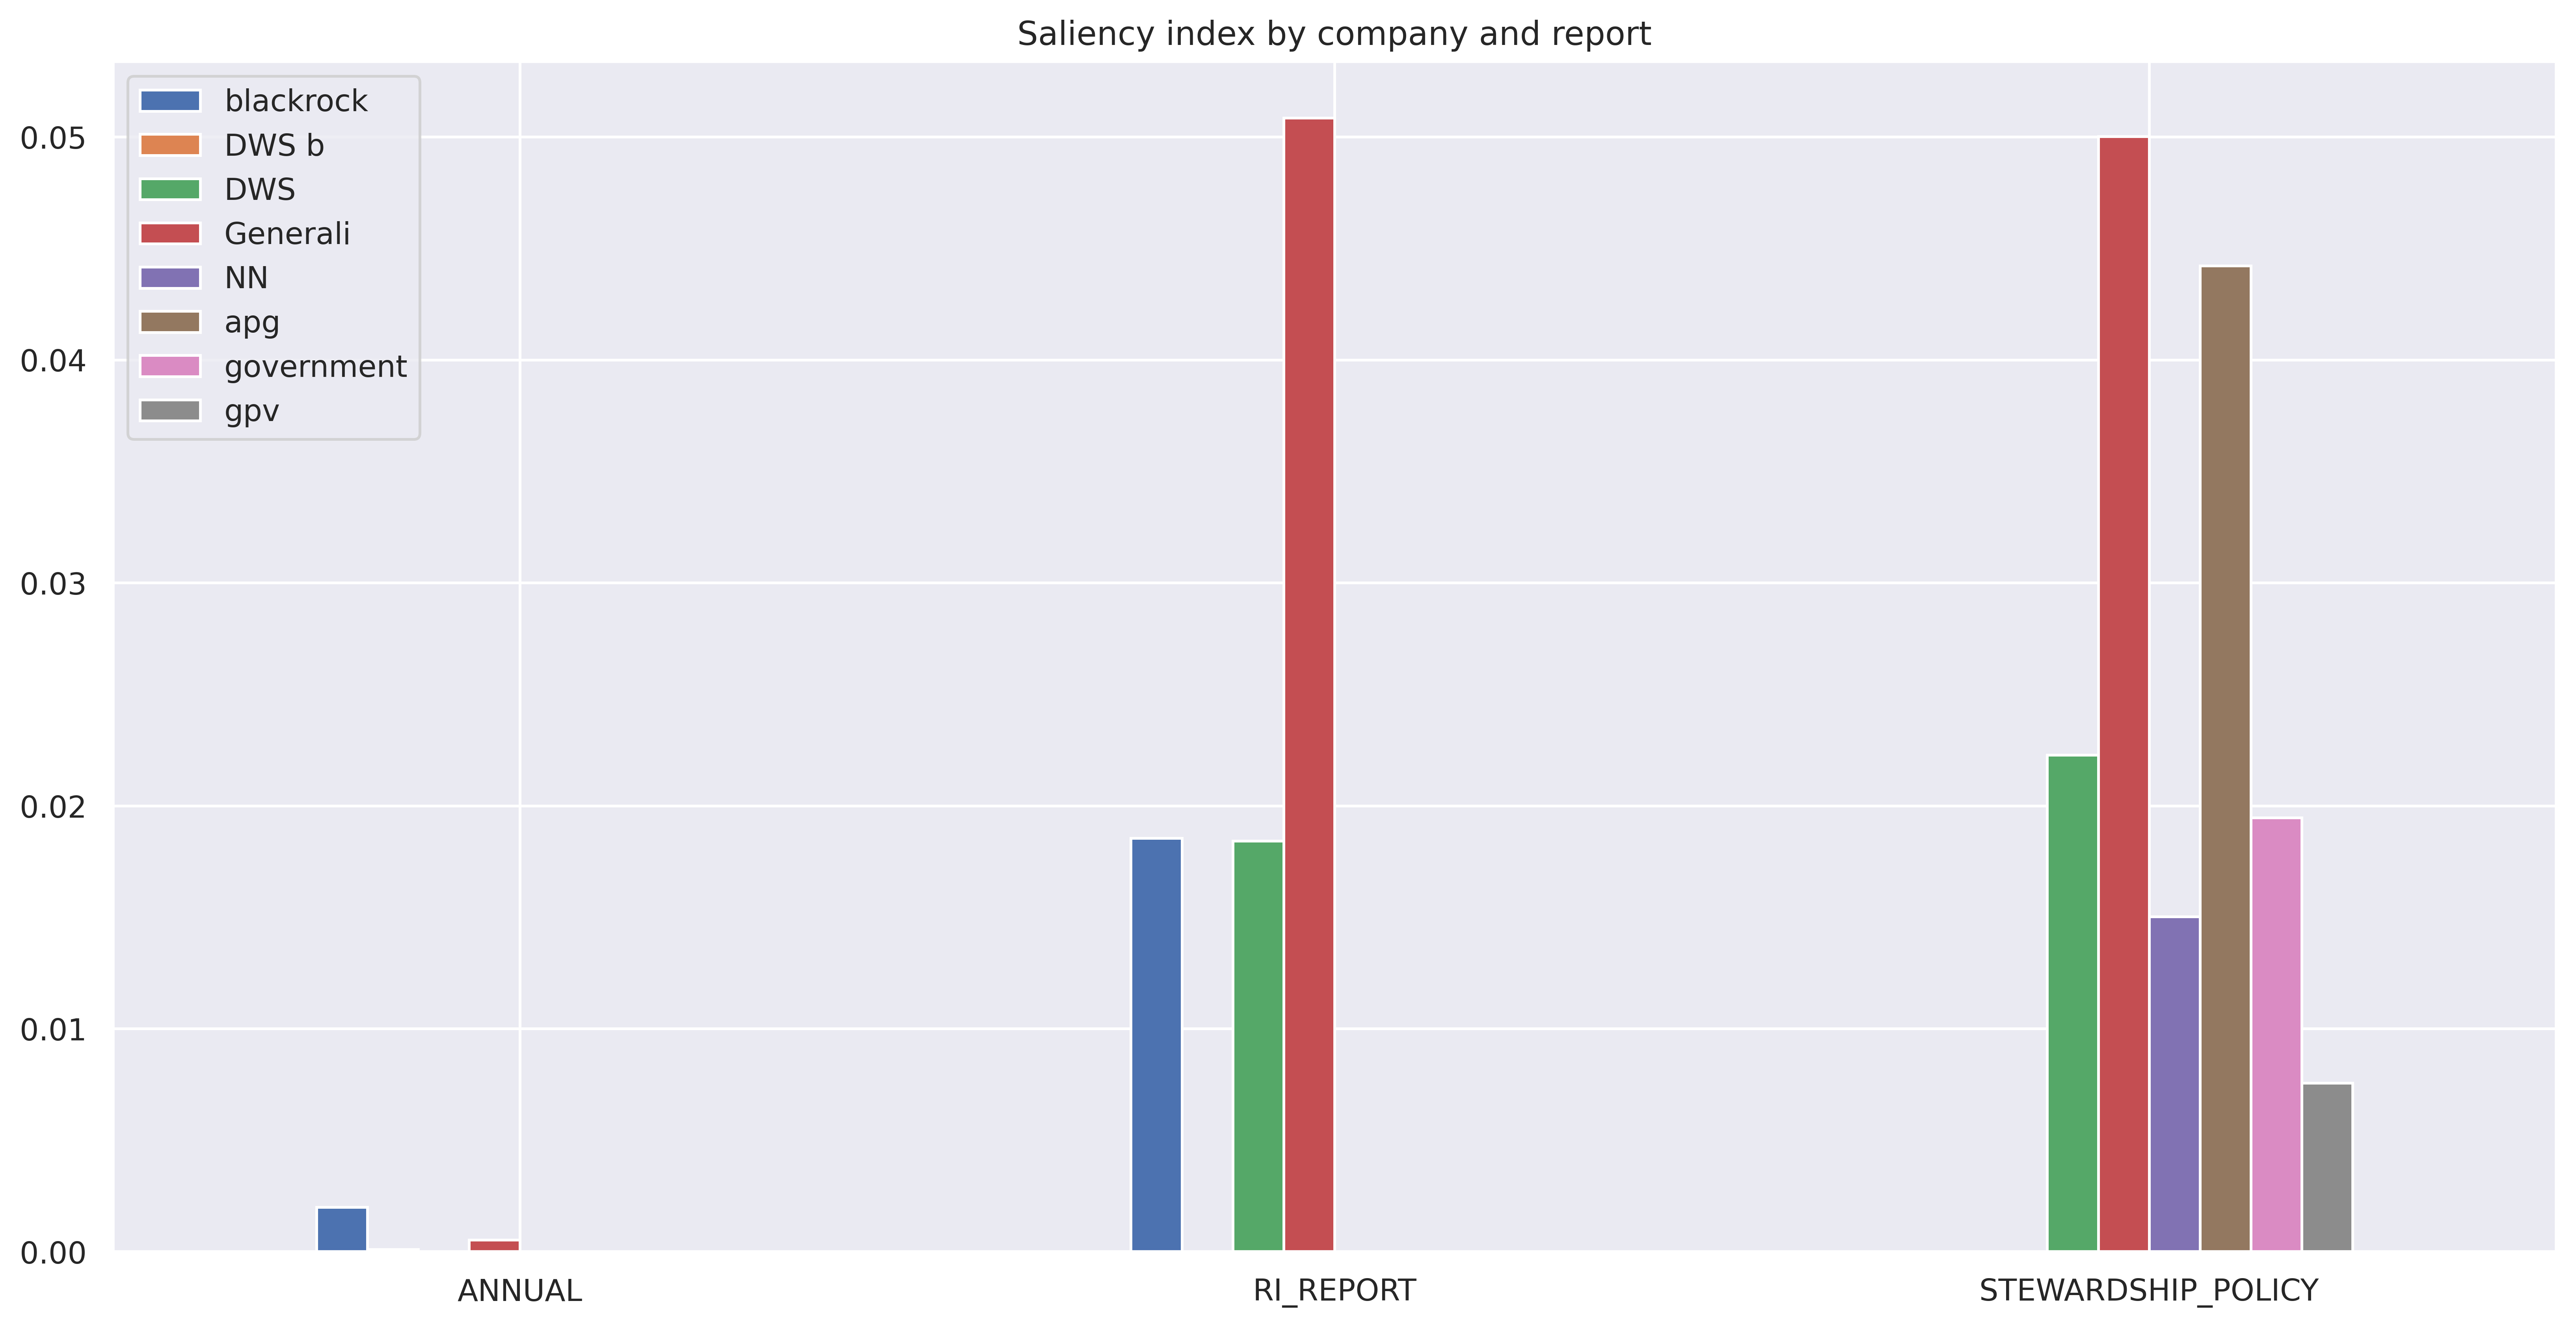

In [46]:
fig, ax = plt.subplots(dpi = 500)
df.T.plot.bar(rot=0, ax=ax)
ax.set_title("Saliency index by company and report")
plt.show()